<a href="https://colab.research.google.com/github/yhutagal/Audio-Watermarking-DWT-SVD/blob/master/Copy_of_Stock_Prediction_%5BSimple_Machine_Learning%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

     |████████████████████████████████| 62 kB 1.1 MB/s 


In [ ]:
# Yahoo Stock Price API package
import yfinance

# Data Manipulation packages
import pandas as pd
import numpy as np
import datetime as dt

# Visualization
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# EDA & Preprocessor packages
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

# ML model packages
from sklearn.linear_model import LinearRegression

# Evaluation Metrics packages
from sklearn.metrics import mean_squared_error, mean_absolute_error

# For Logging Purpose
# Connect to gsheets
from google.colab import auth, files, drive
import gspread
from google.auth import default

## Parameters

In [ ]:
## DATASET CONFIGURATION ##
gmt = 7 # GMT+7
today = dt.datetime.now() + dt.timedelta(hours=gmt) 
parameters = {
    "stock_market_detail": {
        "ticker": "APIC.JK",
        "start_date": "1993-02-01",
        "end_date": "2022-10-1",
        "used_cols": ["Open", "High", "Low", "Close"]
    },
    "preprocessing_hyperparameters": {
        "window": 12,
        "rolling_agg": "mean",
        "fillna": -99999 # will not be used if dropna == True
    },
    "preprocessing_treatments": {
        "rolling_window": False,
        "dropna": True
    },
    "feature_extraction": {
        "high_low_pct": True,
        "pct_change": True
    },
    "data_preparation": {
        "features": ["Open", "High", "Low"],
        "target_prediction": "Close",
        "test_size": .3,
        "validation_size": 0,
        "n_in": 3
    }
}



# Run Here

## Initialization

In [ ]:
# Download stock market data
stock_market = yfinance.download(
    parameters["stock_market_detail"]["ticker"],
    start=parameters["stock_market_detail"]["start_date"],
    end=parameters["stock_market_detail"]["end_date"]
)

# Select only necessary features
stock_market = stock_market.loc[:, parameters["stock_market_detail"]["used_cols"]]

[*********************100%***********************]  1 of 1 completed


In [ ]:
display(stock_market)

,Open,High,Low,Close
Date,,,,
2004-02-13,1371.621704,1410.810913,1332.432495,1332.432495
2004-02-16,1371.621704,1450.000122,1371.621704,1371.621704
2004-02-17,1410.810913,1410.810913,1293.243286,1332.432495
2004-02-18,1371.621704,1410.810913,1214.864990,1254.054077
2004-02-19,1254.054077,1332.432495,1214.864990,1332.432495
...,...,...,...,...
2022-10-24,1160.000000,1160.000000,1145.000000,1145.000000
2022-10-25,1145.000000,1150.000000,1140.000000,1150.000000
2022-10-26,1150.000000,1155.000000,1140.000000,1150.000000


## EDA

In [ ]:
# Set Figure Formatting
sns.set()

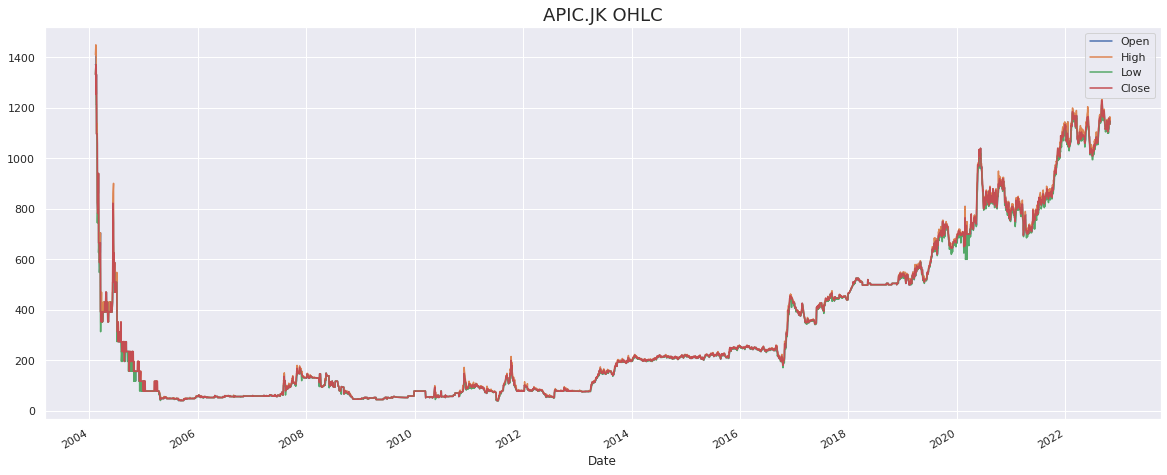

In [ ]:
stock_market.plot(figsize=(20, 8))
plt.title(parameters["stock_market_detail"]["ticker"] + " OHLC", size=18)
plt.show()

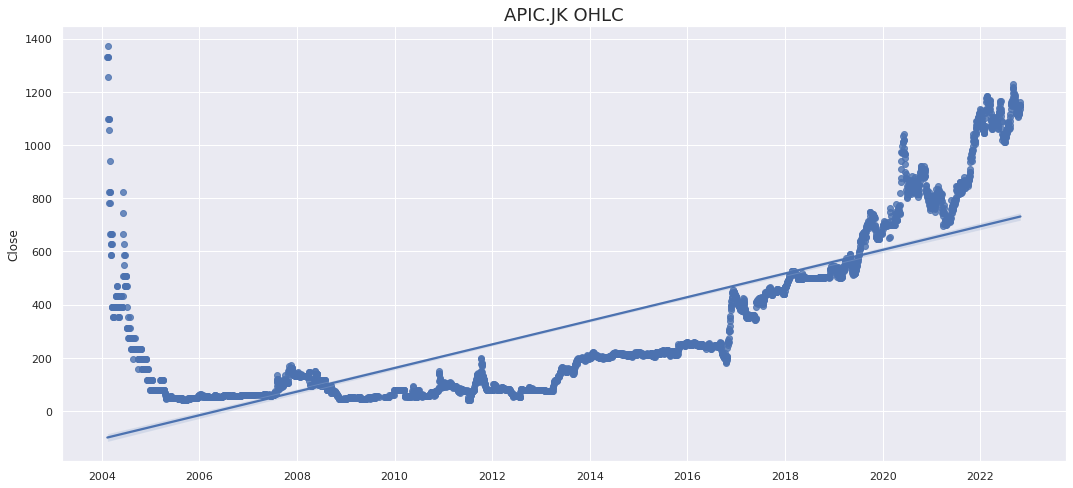

In [ ]:
# Plot Regression for the Close
x = stock_market.index
y = stock_market[parameters["data_preparation"]["target_prediction"]]

# Draw the chart
fig, ax = plt.subplots(figsize=(18, 8))
ax.xaxis.update_units(x)
x = ax.xaxis.convert_units(x)
sns.regplot(x=x, y=y)
plt.title(parameters["stock_market_detail"]["ticker"] + " OHLC", size=18)
plt.show()

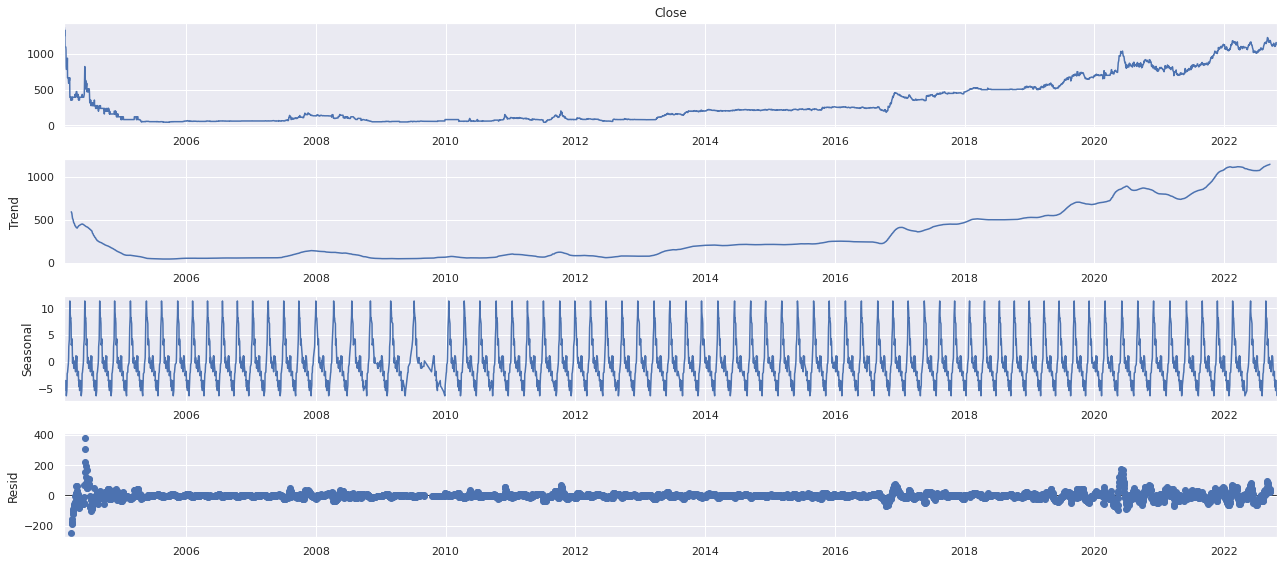

In [ ]:
# Because we want to know yearly seasonal, we set the period 60, means 5 years == 1 seasonal
decomposed = seasonal_decompose(y, model="additive", period=60)
decomposed_fig = decomposed.plot()
decomposed_fig.set_size_inches((18, 8))
decomposed_fig.tight_layout()
plt.show()

## Preprocessing & Feature Extraction

In [ ]:
preprocessed_stock_market = stock_market.copy()

In [ ]:
# Smoothing
if parameters["preprocessing_treatments"]["rolling_window"]:
  preprocessed_stock_market = getattr(
      preprocessed_stock_market.rolling(parameters["preprocessing_hyperparameters"]["window"]), 
      parameters["preprocessing_hyperparameters"]["rolling_agg"]
      )()

  preprocessed_stock_market.plot(figsize=(18, 8))
  plt.title(parameters["stock_market_detail"]["ticker"] + " OHLC", size=18)
  plt.show()

In [ ]:
if parameters["preprocessing_treatments"]["dropna"]:
  preprocessed_stock_market = preprocessed_stock_market.dropna()
else:
  preprocessed_stock_market = preprocessed_stock_market.fillna(parameters["preprocessing_hyperparameters"]["fillna"])

In [ ]:
def list_is_subset(subset_list, global_list, how="all"):
  subset_set = set(subset_list)
  global_set = set(global_list)
  n_intersection = len(subset_set.intersection(global_set))
  if how == "all":
    n_subset_set = len(subset_set)
    if n_subset_set == n_intersection:
      return True
    return False
  elif how == "any":
    if n_intersection > 0:
      return True
    return False


In [ ]:
# Extract High & Low percentage
mandatory_features = ["High", "Low", "Close"]
if parameters["feature_extraction"]["high_low_pct"] and list_is_subset(mandatory_features, parameters["stock_market_detail"]["used_cols"]):
  preprocessed_stock_market.loc[:, "high_low_pct"] = (preprocessed_stock_market["High"] - preprocessed_stock_market["Low"]) / preprocessed_stock_market["Close"] * 100

  # Add new feature as additional predictor feature
  if "high_low_pct" not in parameters["data_preparation"]["features"]:
    parameters["data_preparation"]["features"] += ["high_low_pct"]

In [ ]:
# Extract Percent Change
mandatory_features = ["Open", "Close"]
if parameters["feature_extraction"]["pct_change"] and list_is_subset(mandatory_features, parameters["stock_market_detail"]["used_cols"]):
  preprocessed_stock_market.loc[:, "pct_change"] = (preprocessed_stock_market["Close"] - preprocessed_stock_market["Open"]) / preprocessed_stock_market["Open"] * 100

  # Add new feature as additional predictor feature
  if "pct_change" not in parameters["data_preparation"]["features"]:
    parameters["data_preparation"]["features"] += ["pct_change"]

## Preparing the Dataset & Modelling

### Regression

#### Convert Data to Supervised Format

In [ ]:
def series_to_supervised(data, target_col, n_in=1, n_out=1, dropnan=True):
  """
  Frame a time series as a supervised learning dataset.
  Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
  Returns:
    Pandas DataFrame of series framed for supervised learning.
  """
  vars = data.columns
  df = pd.DataFrame(data)
  cols, in_names, out_names = [], [], []
  target_cols = []
  non_target_cols = []
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    in_names += [f'{col_name}(t-{i})' for col_name in vars]
    non_target_cols.append(f"{target_col}(t-{i})")
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      out_names += [f'{col_name}(t)' for col_name in vars]
      target_cols.append(f'{target_col}(t)')
    else:
      out_names += [f'{col_name}(t+{i})' for col_name in vars]
      target_cols.append(f'{target_col}(t+{i})')
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = in_names + out_names
  out_names = [col for col in out_names if col not in target_cols]
  in_names = [col for col in in_names if col not in non_target_cols]
  agg = agg.drop(out_names + non_target_cols, axis=1)
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg, in_names, target_cols

In [ ]:
preprocessed_stock_market_spv, in_names, out_names = series_to_supervised(
    preprocessed_stock_market, 
    target_col=parameters["data_preparation"]["target_prediction"], 
    n_in=parameters["data_preparation"]["n_in"])

In [ ]:
preprocessed_stock_market

,Open,High,Low,Close,high_low_pct,pct_change
Date,,,,,,
2004-02-13,1371.621704,1410.810913,1332.432495,1332.432495,5.882356,-2.857144
2004-02-16,1371.621704,1450.000122,1371.621704,1371.621704,5.714288,0.000000
2004-02-17,1410.810913,1410.810913,1293.243286,1332.432495,8.823533,-5.555558
2004-02-18,1371.621704,1410.810913,1214.864990,1254.054077,15.624998,-8.571432
2004-02-19,1254.054077,1332.432495,1214.864990,1332.432495,8.823524,6.250003
...,...,...,...,...,...,...
2022-10-24,1160.000000,1160.000000,1145.000000,1145.000000,1.310044,-1.293103
2022-10-25,1145.000000,1150.000000,1140.000000,1150.000000,0.869565,0.436681
2022-10-26,1150.000000,1155.000000,1140.000000,1150.000000,1.304348,0.000000


In [ ]:
preprocessed_stock_market_spv

,Open(t-3),High(t-3),Low(t-3),high_low_pct(t-3),pct_change(t-3),Open(t-2),High(t-2),Low(t-2),high_low_pct(t-2),pct_change(t-2),Open(t-1),High(t-1),Low(t-1),high_low_pct(t-1),pct_change(t-1),Close(t)
Date,,,,,,,,,,,,,,,,
2004-02-18,1371.621704,1410.810913,1332.432495,5.882356,-2.857144,1371.621704,1450.000122,1371.621704,5.714288,0.000000,1410.810913,1410.810913,1293.243286,8.823533,-5.555558,1254.054077
2004-02-19,1371.621704,1450.000122,1371.621704,5.714288,0.000000,1410.810913,1410.810913,1293.243286,8.823533,-5.555558,1371.621704,1410.810913,1214.864990,15.624998,-8.571432,1332.432495
2004-02-20,1410.810913,1410.810913,1293.243286,8.823533,-5.555558,1371.621704,1410.810913,1214.864990,15.624998,-8.571432,1254.054077,1332.432495,1214.864990,8.823524,6.250003,1097.297363
2004-02-23,1371.621704,1410.810913,1214.864990,15.624998,-8.571432,1254.054077,1332.432495,1214.864990,8.823524,6.250003,1332.432495,1332.432495,1097.297363,21.428570,-17.647058,1097.297363
2004-02-24,1254.054077,1332.432495,1214.864990,8.823524,6.250003,1332.432495,1332.432495,1097.297363,21.428570,-17.647058,1097.297363,1097.297363,1097.297363,0.000000,0.000000,1097.297363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24,1115.000000,1125.000000,1110.000000,1.333333,0.896861,1125.000000,1145.000000,1120.000000,2.183406,1.777778,1145.000000,1160.000000,1140.000000,1.724138,1.310044,1145.000000
2022-10-25,1125.000000,1145.000000,1120.000000,2.183406,1.777778,1145.000000,1160.000000,1140.000000,1.724138,1.310044,1160.000000,1160.000000,1145.000000,1.310044,-1.293103,1150.000000
2022-10-26,1145.000000,1160.000000,1140.000000,1.724138,1.310044,1160.000000,1160.000000,1145.000000,1.310044,-1.293103,1145.000000,1150.000000,1140.000000,0.869565,0.436681,1150.000000


In [ ]:
parameters["data_preparation"]["features"] = in_names
parameters["data_preparation"]["target_prediction"] = out_names

#### Split Dataset

In [ ]:
def ts_test_data_splitter(data, test_size):
  test_index = int(np.ceil(test_size * len(data)))
  training_data = data[:-test_index]
  testing_data = data[-test_index:]
  return training_data, testing_data

In [ ]:
training, testing = ts_test_data_splitter(preprocessed_stock_market_spv, parameters["data_preparation"]["test_size"])

In [ ]:
X_train = training[parameters["data_preparation"]["features"]]
y_train = training[parameters["data_preparation"]["target_prediction"]].values
X_test = testing[parameters["data_preparation"]["features"]]
y_test = testing[parameters["data_preparation"]["target_prediction"]].values

In [ ]:
# Scale X to get similar distribution
# Note: only fit on training data to avoid data leakage
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Linear Regression

In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# R2
r2_score = model.score(X_test_scaled, y_test)
prediction = model.predict(X_test_scaled)
rmse_score = np.sqrt(mean_squared_error(y_test, prediction))
mae_score = mean_absolute_error(y_test, prediction)
print("R2 score   :", r2_score)
print("RMSE score :", rmse_score)
print("MAE score  :", mae_score)

R2 score   : 0.995288851996888
RMSE score : 15.585560243764506
MAE score  : 9.941483072210454


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.arange(len(y_test)),
    y=y_test[:, 0],
    name="Y True"
))

fig.add_trace(go.Scatter(
    x=np.arange(len(prediction)),
    y=prediction[:, 0],
    name="Y Prediction"
))

fig.update_layout(
    title={
        'text': "Y True and Y Prediction",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Value",
    autosize=True,
    width=1200,
    height=400,
    margin=dict(
        l=5,
        r=40,
        b=50,
        t=50,
        pad=1
    ),
    legend=dict(
      yanchor="top",
      y=0.99,
      xanchor="left",
      x=0.01,
      orientation="h"
  )
)

fig.show()

In [ ]:
comparison_df = pd.DataFrame(zip(y_test[:, 0], prediction[:, 0]), columns=["Ground Truth", "Prediction"])

In [ ]:
comparison_df

,Ground Truth,Prediction
0,412.0,404.764674
1,416.0,406.044631
2,420.0,412.577857
3,418.0,417.962721
4,410.0,418.994355
...,...,...
1348,1145.0,1142.717743
1349,1150.0,1146.406201
1350,1150.0,1142.927705
1351,1145.0,1141.988574


## Store the result

In [ ]:
def connect_to_gsheet():
  #autenticating to google
  auth.authenticate_user()
  creds, _ = default()
  gc = gspread.authorize(creds)
  return gc

def get_worksheet(gc, worksheet_name):
  #defining my worksheet
  worksheet = gc.open(worksheet_name)
  return worksheet

In [ ]:
# Connect to gsheet
gc = connect_to_gsheet()

# Params
logging_filename = "Stock Price Log"
approach_sheetname = "Approach 1"
worksheet = get_worksheet(gc, logging_filename)

approach_sheet = worksheet.worksheet(approach_sheetname)

In [ ]:
values = {
    "created_at": str(dt.datetime.now() + dt.timedelta(hours=7)),
    "ticker": parameters["stock_market_detail"]["ticker"],
    "start_date": parameters["stock_market_detail"]["start_date"],
    "end_date": parameters["stock_market_detail"]["end_date"],
    "used_cols": str(parameters["stock_market_detail"]["used_cols"]),
    "rolling_window": parameters["preprocessing_treatments"]["rolling_window"],
    "dropna": parameters["preprocessing_treatments"]["dropna"],
    "n_window": parameters["preprocessing_hyperparameters"]["window"],
    "rolling_agg": parameters["preprocessing_hyperparameters"]["rolling_agg"],
    "fillna": parameters["preprocessing_hyperparameters"]["fillna"],
    "fe_hl_pct": parameters["feature_extraction"]["high_low_pct"],
    "fe_pct_change": parameters["feature_extraction"]["pct_change"],
    "n_in": str(parameters["data_preparation"]["n_in"]),
    "y": str(parameters["data_preparation"]["target_prediction"]),
    "test_size": parameters["data_preparation"]["test_size"],
    "r2": r2_score,
    "rmse": rmse_score,
    "mae": mae_score
}
values = list(values.values())
approach_sheet.append_row(values=values)

{'spreadsheetId': '1d60bzoTE2ft6DTfUU6rGzFXlb90vmssUn6_GdZMlofw',
 'tableRange': "'Approach 1'!A1:S13",
 'updates': {'spreadsheetId': '1d60bzoTE2ft6DTfUU6rGzFXlb90vmssUn6_GdZMlofw',
  'updatedRange': "'Approach 1'!A14:R14",
  'updatedRows': 1,
  'updatedColumns': 18,
  'updatedCells': 18}}

### Classification

> Kita perlu memastikan apakah performa dari regresi benar-benar teruji dengan klasifikasi

#### Convert to classification problem

In [ ]:
preprocessed_stock_market["is_bear"] = preprocessed_stock_market["Close"].shift(-1) - preprocessed_stock_market["Close"] > 0

# Trim last data
preprocessed_stock_market["is_bear"] = preprocessed_stock_market["is_bear"].shift(1)

# Dropna
preprocessed_stock_market_clf = preprocessed_stock_market.dropna()

# Change parameter
parameters["data_preparation"]["target_prediction"] = "is_bear"

In [ ]:
preprocessed_stock_market_clf.iloc[:7]

,Open,High,Low,Close,high_low_pct,pct_change,is_bear
Date,,,,,,,
2004-02-16,1371.621704,1450.000122,1371.621704,1371.621704,5.714288,0.000000,True
2004-02-17,1410.810913,1410.810913,1293.243286,1332.432495,8.823533,-5.555558,False
2004-02-18,1371.621704,1410.810913,1214.864990,1254.054077,15.624998,-8.571432,False
2004-02-19,1254.054077,1332.432495,1214.864990,1332.432495,8.823524,6.250003,True
2004-02-20,1332.432495,1332.432495,1097.297363,1097.297363,21.428570,-17.647058,False
2004-02-23,1097.297363,1097.297363,1097.297363,1097.297363,0.000000,0.000000,False
2004-02-24,1136.486572,1136.486572,1058.108154,1097.297363,7.142860,-3.448277,False


#### Convert Data to Supervised Format

In [ ]:
preprocessed_stock_market_clf, in_names, out_names = series_to_supervised(
    preprocessed_stock_market_clf, 
    target_col=parameters["data_preparation"]["target_prediction"], 
    n_in=parameters["data_preparation"]["n_in"])

In [ ]:
preprocessed_stock_market_clf

,Open(t-3),High(t-3),Low(t-3),Close(t-3),high_low_pct(t-3),pct_change(t-3),Open(t-2),High(t-2),Low(t-2),Close(t-2),high_low_pct(t-2),pct_change(t-2),Open(t-1),High(t-1),Low(t-1),Close(t-1),high_low_pct(t-1),pct_change(t-1),is_bear(t)
Date,,,,,,,,,,,,,,,,,,,
2004-02-19,1371.621704,1450.000122,1371.621704,1371.621704,5.714288,0.000000,1410.810913,1410.810913,1293.243286,1332.432495,8.823533,-5.555558,1371.621704,1410.810913,1214.864990,1254.054077,15.624998,-8.571432,True
2004-02-20,1410.810913,1410.810913,1293.243286,1332.432495,8.823533,-5.555558,1371.621704,1410.810913,1214.864990,1254.054077,15.624998,-8.571432,1254.054077,1332.432495,1214.864990,1332.432495,8.823524,6.250003,False
2004-02-23,1371.621704,1410.810913,1214.864990,1254.054077,15.624998,-8.571432,1254.054077,1332.432495,1214.864990,1332.432495,8.823524,6.250003,1332.432495,1332.432495,1097.297363,1097.297363,21.428570,-17.647058,False
2004-02-24,1254.054077,1332.432495,1214.864990,1332.432495,8.823524,6.250003,1332.432495,1332.432495,1097.297363,1097.297363,21.428570,-17.647058,1097.297363,1097.297363,1097.297363,1097.297363,0.000000,0.000000,False
2004-02-25,1332.432495,1332.432495,1097.297363,1097.297363,21.428570,-17.647058,1097.297363,1097.297363,1097.297363,1097.297363,0.000000,0.000000,1136.486572,1136.486572,1058.108154,1097.297363,7.142860,-3.448277,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24,1115.000000,1125.000000,1110.000000,1125.000000,1.333333,0.896861,1125.000000,1145.000000,1120.000000,1145.000000,2.183406,1.777778,1145.000000,1160.000000,1140.000000,1160.000000,1.724138,1.310044,False
2022-10-25,1125.000000,1145.000000,1120.000000,1145.000000,2.183406,1.777778,1145.000000,1160.000000,1140.000000,1160.000000,1.724138,1.310044,1160.000000,1160.000000,1145.000000,1145.000000,1.310044,-1.293103,True
2022-10-26,1145.000000,1160.000000,1140.000000,1160.000000,1.724138,1.310044,1160.000000,1160.000000,1145.000000,1145.000000,1.310044,-1.293103,1145.000000,1150.000000,1140.000000,1150.000000,0.869565,0.436681,False


In [ ]:
# Drop unused column
unused_cols = preprocessed_stock_market_clf.filter(regex="Close").columns
in_names = [col for col in in_names if col not in unused_cols]

In [ ]:
parameters["data_preparation"]["features"] = in_names
parameters["data_preparation"]["target_prediction"] = out_names

#### Split Dataset

In [ ]:
training, testing = ts_test_data_splitter(preprocessed_stock_market_clf, parameters["data_preparation"]["test_size"])

In [ ]:
X_train = training[parameters["data_preparation"]["features"]]
y_train = training[parameters["data_preparation"]["target_prediction"]].astype(int)
X_test = testing[parameters["data_preparation"]["features"]]
y_test = testing[parameters["data_preparation"]["target_prediction"]].astype(int)

In [ ]:
# Scale X to get similar distribution
# Note: only fit on training data to avoid data leakage
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier

In [ ]:
model = LogisticRegression(max_iter=50)
model.fit(X_train_scaled, y_train)

prediction = model.predict(X_test_scaled)
acc_score = accuracy_score(y_test, prediction)
cm = confusion_matrix(y_test, prediction)

print("Acc score   :", acc_score)
print("\n", classification_report(y_test, prediction))

Acc score   : 0.3887657058388766

               precision    recall  f1-score   support

           0       0.69      0.16      0.25       903
           1       0.34      0.86      0.48       450

    accuracy                           0.39      1353
   macro avg       0.51      0.51      0.37      1353
weighted avg       0.57      0.39      0.33      1353



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



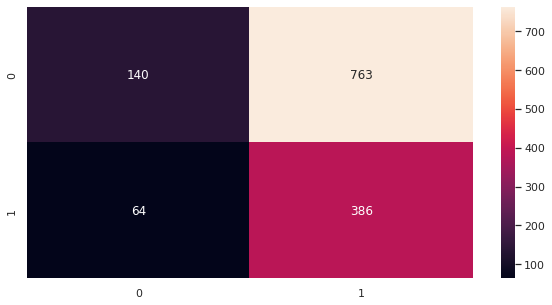

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt=".0f")
plt.show()

In [ ]:
model = XGBClassifier()
model.fit(X_train_scaled, y_train)

prediction = model.predict(X_test_scaled)
acc_score = accuracy_score(y_test, prediction)
cm = confusion_matrix(y_test, prediction)

print("Acc score   :", acc_score)
print("\n", classification_report(y_test, prediction))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Acc score   : 0.6674057649667405

               precision    recall  f1-score   support

           0       0.67      1.00      0.80       903
           1       0.50      0.01      0.01       450

    accuracy                           0.67      1353
   macro avg       0.58      0.50      0.41      1353
weighted avg       0.61      0.67      0.54      1353



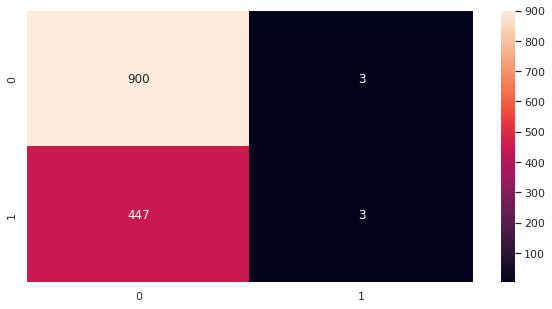

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt=".0f")
plt.show()